In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline
# %load_ext jupyter_black

## Reading Data


In [3]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [4]:
forward_df = pd.read_csv("../results/forward_df.csv")
backward_df = pd.read_csv("../results/backward_df.csv")
backward_df_unscaled = pd.read_csv("../results/backward_df_unscaled.csv")
scaled_brier_df = pd.read_csv("../results/scaled_brier_df.csv")

In [19]:
backward_df_unscaled["lbound"] = 1

## Simulate With Fitted Params

In [20]:
from Forward import simulate_with_params, simulate_with_params_one
from Utility import merge_result_df

# forward_simulation_df = simulate_with_params(forward_df, lv_induction_data, subjects, n= 100)
# backward_simulation_df = simulate_with_params(backward_df, lv_induction_data, subjects, n= 100)
backward_unscaled_simulation_df = simulate_with_params(backward_df_unscaled, lv_induction_data, subjects, n= 100)

# forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
# backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_unscaled_simulation_df.rename(columns={"sub": "subject"}, inplace=True)

human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

In [ ]:
forward_simulation_df.to_csv("../results/forward_simulation_df.csv")
backward_simulation_df.to_csv("../results/backward_simulation_df.csv")

In [6]:
forward_simulation_df = pd.read_csv("../results/forward_simulation_df.csv")
backward_simulation_df = pd.read_csv("../results/backward_simulation_df.csv")

In [151]:
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                    var_df=pd.DataFrame()):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.wilcoxon(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

In [203]:
def plot_histogtram(x, color,xlabel):
    seaborn.histplot(
        x=x,
        color=color,
        stat="count",
        bins=20,
        edgecolor=color,
    )

    plt.ylabel("Number of Subjects", fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    
    print("mean for {} = {}".format(xlabel,x.mean()))
    print("sd for {} = {}".format(xlabel,x.std()))


# plt.savefig("../figs/Meta_RL_hist.png", dpi=400)



In [21]:
subjects_avg_df = (
    human_lv_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
forward_avg_df = (
    forward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
backward_avg_df = (
    backward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
backward_unscaled_avg_df = (
    backward_unscaled_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)

groups = ["Forward", "Empirical", "Backward"]

avg_df = merge_result_df(
    [forward_avg_df, subjects_avg_df, backward_avg_df], groups, 200, subjects
)
avg_df.rename(
    columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
    inplace=True,
)

In [52]:
groups = ["Forward", "Backward"]

params_df =  merge_result_df(
    [forward_df, backward_df], groups, 200, subjects
)


Statistics=18.0, p=9.026e-08


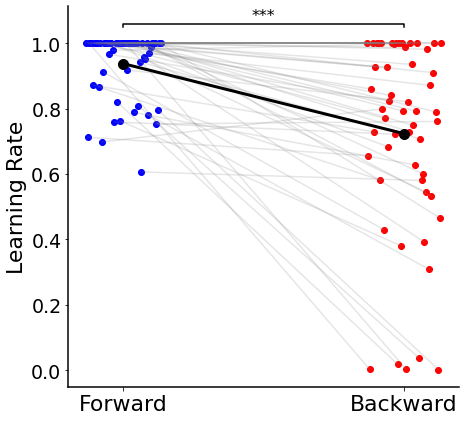

In [301]:
plt.figure(figsize=(7, 7))
comparison_plot(
    params_df,
    "alpha",
    groups,
    "",
    [["Forward", "Backward"]],
    [1.05, 1.05],
    [0.01, 0.01],
    y_label="Learning Rate",
)
plt.savefig("../figs/params_alpha_compare.png", dpi=400, bbox_inches = "tight")

In [302]:
print(",".join([str(a) for a in params_df[params_df["model"] == "Forward"]["alpha"]]))
print(",".join([str(a) for a in params_df[params_df["model"] == "Backward"]["alpha"]]))


1.0,0.7121769014690096,1.0,1.0,1.0,0.8713134123109646,1.0,1.0,1.0,0.8661179265060038,1.0,0.697759173851887,0.9124748449911798,1.0,1.0,1.0,0.9664672205373988,1.0,1.0,0.978349934885755,0.7591238626681888,1.0,0.8207090128600937,1.0,0.7630623718648354,1.0,1.0,1.0,1.0,0.9180640594761632,1.0,1.0,1.0,1.0,0.788271878224487,1.0,1.0,0.8092899293052075,0.942810378749163,0.6061368052245125,1.0,0.956348179682006,0.9517322479586896,1.0,0.7817657153136605,0.9695825260766504,0.9879728522562692,1.0,1.0,1.0,0.7530572004757553,0.7971083929874196,1.0,1.0
1.0,0.6553864922596101,0.0024384444145776,0.8598212756360274,1.0,0.7287641617504254,0.9278359354805532,1.0,1.0,0.5821764861004047,1.0,0.7989723073218475,0.4297058934854972,0.7699818401649422,0.9256547850236962,0.6833446458671583,0.8227015386247551,0.8401938864816213,1.0,0.9967083410706928,0.721473635135694,1.0,0.0173614271664448,1.0,0.3805910750247936,1.0,0.7926152707477112,0.9868323211396376,0.002063424521989,0.8207312369096126,0.7293588586864606,1.0,0.9

Statistics=299.0, p=1.342e-04


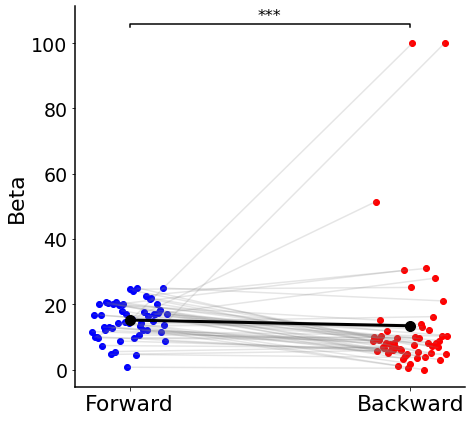

In [303]:
plt.figure(figsize=(7, 7))
comparison_plot(
    params_df,
    "beta",
    groups,
    "",
    [["Forward", "Backward"]],
    [105, 105],
    [1, 1],
    y_label="Beta",
)
plt.savefig("../figs/params_beta_compare.png", dpi=400, bbox_inches = "tight")

In [304]:
print(",".join([str(a) for a in params_df[params_df["model"] == "Forward"]["beta"]]))
print(",".join([str(a) for a in params_df[params_df["model"] == "Backward"]["beta"]]))


11.60916021474705,16.82774315099871,9.946770061802509,10.014853975748617,9.67220668999822,20.04155952667523,16.674607680922144,7.342097652277155,13.006700117558442,12.04312902273942,20.533366638073915,20.31266223362837,13.030785643062549,4.621028391473235,12.775446353428569,20.04965517394863,5.478362171995458,20.766750550610958,14.30128096182144,19.622320100114084,8.717398338307772,18.00622763999689,20.19837998238575,14.439713455665292,16.927581615961277,0.7000626688951789,14.206018590179513,24.599645733626705,15.394415335607222,24.1900124678646,9.66009770740283,4.595847788776383,25.012477306825517,10.597426737213988,13.366981956654538,14.16112566849265,12.04670433184888,17.695515075072326,22.63215423980296,12.070791936893558,16.34285663983103,21.58273766713553,21.84955038695844,14.77269461347833,16.93496924631274,16.911053467630065,20.150351745642016,17.29325569203876,18.18061993700813,11.570493262772558,24.980164340742327,13.766958930878564,8.74251972983112,16.92143054885225
8.851364

In [305]:
filtered_params_df = params_df[params_df["subject"]!= 46489.0]

Statistics=0.0, p=1.626e-10


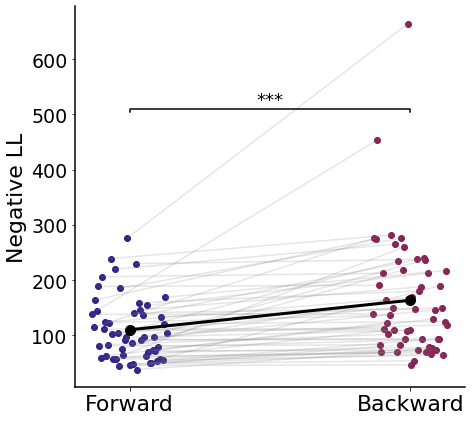

In [53]:
plt.figure(figsize=(7, 7))
comparison_plot(
    params_df,
    "LL",
    groups,
    "",
    [["Forward", "Backward"]],
    [505, 405],
    [5, 1],
    y_label="Negative LL",
)
plt.savefig("../figs/Neg_LL_compare.png", dpi=400, bbox_inches = "tight")

In [307]:
print(",".join([str(a) for a in filtered_params_df[filtered_params_df["model"] == "Forward"]["LL"]]))
print(",".join([str(a) for a in filtered_params_df[filtered_params_df["model"] == "Backward"]["LL"]]))


137.99792249744604,114.86050939237018,164.28611034324504,144.47523264268114,188.69221766825905,80.950285072926,59.64934461577042,206.22045880635756,111.4910523730869,123.91629011399458,63.31196992519934,83.48602120338114,123.18773238314095,239.02741343408783,102.37022506155996,57.209268239453706,219.812840699574,56.78357251480055,104.01846368293738,44.654479716579736,185.48483996344757,75.53253124726919,64.28587042572555,92.46118220818369,96.52634057266168,109.43055051000592,45.60859835841016,85.72387188590423,48.66058323703499,140.84336885658772,229.7944489626515,38.24677092113008,159.1038521439246,145.90688847285935,91.60914656900265,137.1493121916369,97.19610766985264,62.13548351280868,154.0953810298875,69.24360630091407,49.32850316384284,50.57055100560992,72.71556223680862,96.43697454773452,71.96206929689875,53.33675180812212,79.34064105098057,57.59463336748647,134.056750935286,55.355754846495984,120.9058478563164,168.71833000019814,104.31865602874458
141.84390984229657,134.2852924

Statistics=0.0, p=1.626e-10


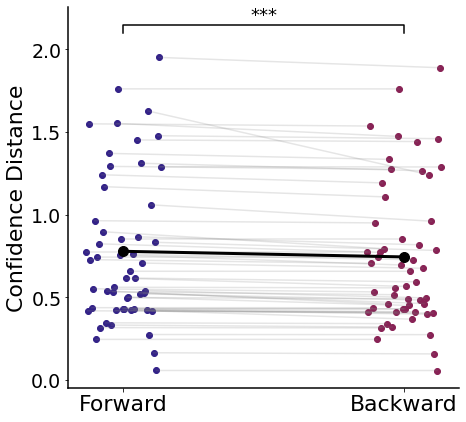

In [57]:
plt.figure(figsize=(7, 7))
groups = ["Forward", "Backward"]

comparison_plot(
    params_df,
    "Confidence Distance",
    groups,
    "",
    [["Forward", "Backward"]],
    [2.1],
    [.05],
    y_label="Confidence Distance",
)
plt.savefig("../figs/conf_compare.png", dpi=400, bbox_inches = "tight")

In [309]:
print(",".join([str(a) for a in params_df[params_df["model"] == "Forward"]["Confidence Distance"]]))
print(",".join([str(a) for a in params_df[params_df["model"] == "Backward"]["Confidence Distance"]]))


0.7744645275404909,0.4188400629629874,1.5497301335381624,0.7284412925584013,0.4377369028244136,0.5519194453425186,0.9637438381781952,0.2459706108408856,0.7437700771244454,0.8239088646254481,0.3173044328094225,1.2416746539925176,0.8969796146034679,1.1694311884909332,0.3462273175594708,0.5383424289767688,1.3709305727621557,1.2922287050233257,0.3324419483963753,0.533868802606637,0.5613177640163067,0.4212144757410426,1.552190591391131,1.761066747477248,0.7561466627947556,0.8516326483472851,0.4306128275261855,0.4323039183430355,0.6151197672279121,0.4991391312229812,0.5009611588384568,0.6579417982734705,0.4225299684672277,0.7595236199859218,0.4275175263242172,0.6165903775324749,1.4522880866283954,0.8662721167740179,0.5222989960960546,1.3113059131372775,0.7076247578067578,0.5251988717075734,0.5415511068430944,0.4227117055499879,1.6276019760952125,0.2754281598729706,1.0598444008128676,0.4168936024142702,0.1651543125570273,0.8331552159316163,0.0578256469373752,1.4777610374124377,1.9513670007424

Statistics=7.0, p=2.407e-10
Statistics=19.0, p=4.679e-10
Statistics=326.0, p=3.356e-04


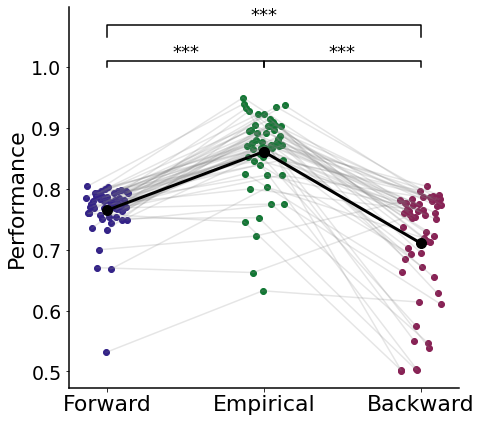

In [34]:
plt.figure(figsize=(7, 7))

groups = ["Forward", "Empirical", "Backward"]


comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)
plt.savefig("../figs/accuracy_compare.png", dpi=400)

Statistics=438.0, p=8.746e-03
Statistics=598.0, p=2.134e-01
Statistics=686.0, p=6.266e-01


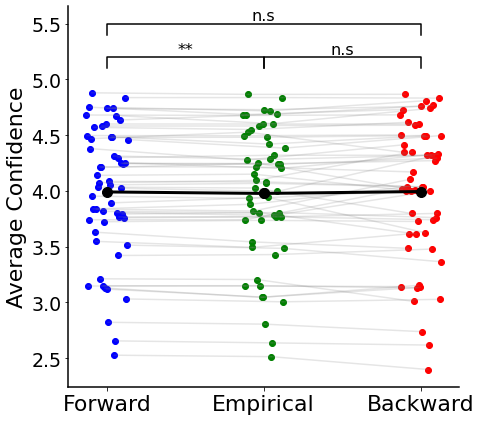

In [464]:
plt.figure(figsize=(7, 7))

groups = ["Forward", "Empirical", "Backward"]

comparison_plot(
    avg_df,
    "mean conf",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [5.1, 5.1, 5.4],
    [0.1, 0.1, 0.1],
    legend="lower right",
    y_label="Average Confidence",
)

plt.savefig("../figs/mean_confs_compare.png", dpi=400)

In [177]:
forward_df

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx
0,0,45628.0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,Forward,1
1,1,45640.0,0.712177,16.827742,4.462571,0.071960,114.860509,0.418840,4.501244,Forward,2
2,2,45664.0,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,Forward,3
3,3,45682.0,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,Forward,4
4,4,45745.0,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,Forward,5
5,5,45760.0,0.871313,20.041560,1.000000,0.929745,80.950285,0.551919,4.718982,Forward,6
6,6,45763.0,1.000000,16.674608,2.498130,0.881425,59.649345,0.963744,4.703341,Forward,7
7,7,45805.0,1.000000,7.342098,4.681814,0.879262,206.220459,0.245971,4.961583,Forward,8
8,8,45829.0,1.000000,13.006700,1.294533,0.847562,111.491052,0.743770,4.435145,Forward,9
9,9,45964.0,0.866118,12.043129,1.579689,0.823172,123.916290,0.823909,4.395193,Forward,10


Statistics for Empirical and Forward =7.0, p=2.407e-10
Statistics for Backward and Empirical =19.0, p=4.679e-10
Statistics for Forward and Backward =326.0, p=3.356e-04
mean Forward = 0.76
mean Empirical = 0.86
mean Backward = 0.71
Statistics for Empirical and Forward =465.0, p=1.688e-02
Statistics for Backward and Empirical =595.0, p=2.041e-01
Statistics for Forward and Backward =691.0, p=6.575e-01
mean Forward = 3.99
mean Empirical = 3.98
mean Backward = 3.99
mean for Negative LL (Forward - Backward) = -53.46022166325774
sd for Negative LL (Forward - Backward) = 75.68051598267647
mean for Confidence Distance (Forward - Backward) = 0.03397835773378246
sd for Confidence Distance (Forward - Backward) = 0.055723087074658444
Statistics for Forward and Backward =27.0, p=4.717e-08
mean Forward = 0.94
mean Backward = 0.66
Statistics for Forward and Backward =531.0, p=6.860e-02
mean Forward = 15.15
mean Backward = 24.11


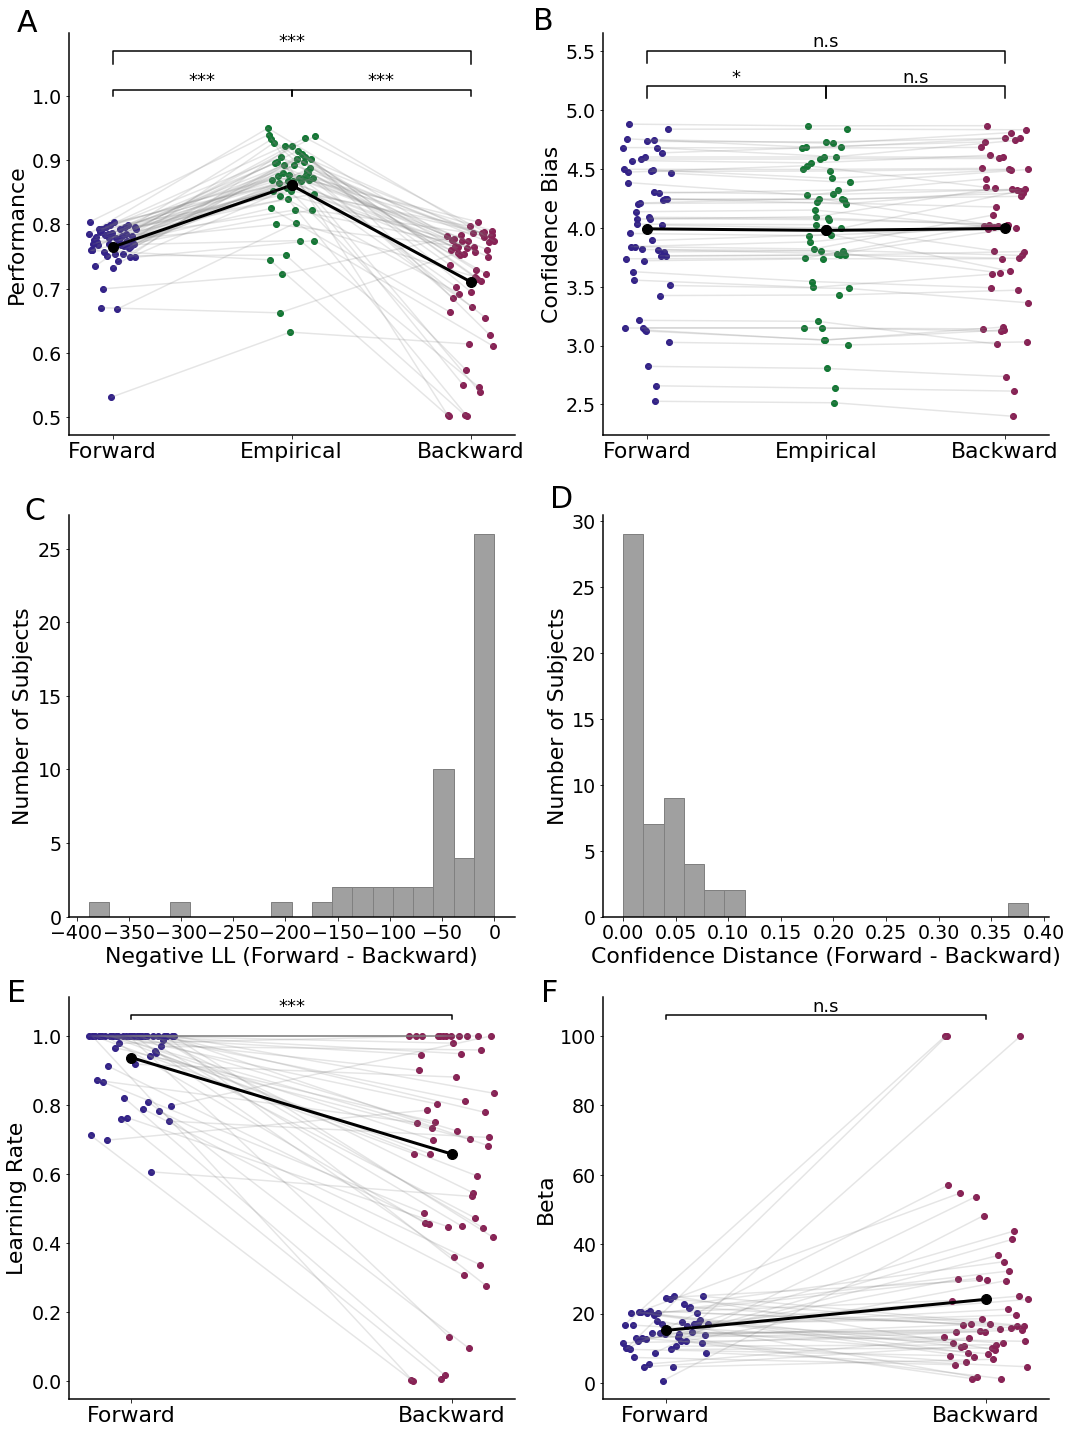

In [204]:
plt.figure(figsize=(15, 20))

plt.subplot(3,2,1)


groups = ["Forward", "Empirical", "Backward"]


comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)

plt.text(-80, 1.1, "A", fontsize=30)


plt.subplot(3,2,2)

plt.text(-100, 5.68, "B", fontsize=30)

groups = ["Forward", "Empirical", "Backward"]

comparison_plot(
    avg_df,
    "mean conf",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [5.1, 5.1, 5.4],
    [0.1, 0.1, 0.1],
    legend="lower right",
    y_label="Confidence Bias",
)

plt.subplot(3,2,3)

plt.text(-450, 27, "C", fontsize=30)

groups = ["Forward", "Backward"]

plot_histogtram(forward_df["LL"] - backward_df["LL"],
                "grey",
                "Negative LL (Forward - Backward)"
)

plt.subplot(3,2,4)

plt.text(-.07, 31, "D", fontsize=30)

plot_histogtram(forward_df["Confidence Distance"] - backward_df["Confidence Distance"],
                "grey",
                "Confidence Distance (Forward - Backward)"
               )


plt.subplot(3,2,5)

plt.text(-50, 1.1, "E", fontsize=30)

comparison_plot(
    params_df,
    "alpha",
    groups,
    "",
    [["Forward", "Backward"]],
    [1.05, 1.05],
    [0.01, 0.01],
    y_label="Learning Rate",
)

plt.subplot(3,2,6)

plt.text(-50, 110, "F", fontsize=30)

comparison_plot(
    params_df,
    "beta",
    groups,
    "",
    [["Forward", "Backward"]],
    [105, 105],
    [1, 1],
    y_label="Beta",
)



plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/forward_backward_comapre.png", dpi=400, bbox_inches = "tight")

In [187]:
backward_df

,Unnamed: 0,subject,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model,x_idx
0,0,45628.0,1.000000,13.260400,4.606821,0.221289,139.034297,0.774456,4.693827,Backward,201
1,1,45640.0,0.003908,100.000000,3.968331,1.000000,275.681213,0.410537,5.000000,Backward,202
2,2,45664.0,0.001108,100.000000,1.270128,1.000000,275.198525,1.536389,5.000000,Backward,203
3,3,45682.0,0.658565,57.058389,2.026065,0.693936,453.480572,0.705934,4.089785,Backward,204
4,4,45745.0,1.000000,7.876816,4.041896,1.000000,190.566009,0.437457,5.000000,Backward,205
5,5,45760.0,0.747970,23.764486,1.000000,0.927304,82.892276,0.533329,4.709216,Backward,206
6,6,45763.0,0.900032,11.528003,2.346942,0.937333,69.632288,0.950495,4.833740,Backward,207
7,7,45805.0,0.945865,5.261946,4.643276,1.000000,212.436678,0.245864,5.000000,Backward,208
8,8,45829.0,1.000000,14.589953,1.331203,0.832861,112.315230,0.742902,4.386802,Backward,209
9,9,45964.0,0.486703,29.946150,1.794287,0.765650,164.947491,0.772505,4.248742,Backward,210


In [313]:
print(",".join([str(a) for a in avg_df[avg_df["model"] == "Forward"]["mean conf"]]))
print(",".join([str(a) for a in avg_df[avg_df["model"] == "Empirical"]["mean conf"]]))
print(",".join([str(a) for a in avg_df[avg_df["model"] == "Backward"]["mean conf"]]))


4.680461461415634,4.496144276585923,3.148277266811359,3.7350762578943306,4.754432422957733,4.382040644465648,4.464031746108169,4.880088916012457,3.9524700990520736,3.8319680911043594,4.571997953880689,3.6220833493815627,3.551549104109202,3.836738906614002,4.134107320997958,4.036243978825853,4.068978844415668,4.20899061668557,3.213290930787741,4.214489206815266,4.586122392340633,3.8157445027908694,3.150456718268052,3.7237082103702392,3.1371364377158626,4.5999629626483385,3.1221127252376575,4.736083663031833,2.820912371542159,4.086924877237452,4.080233145312959,4.477828049666817,3.891521989209015,4.485807794903561,4.748299700631971,4.307233278098735,2.529030747532978,2.6568480533552514,4.676172066951476,3.8132824497595488,4.295198776391496,3.4204855600261443,3.765981681740334,4.63465556623621,4.031323060919589,4.247955594058809,3.7920187280235425,4.24740797355652,3.7597113441201357,4.2412232273821955,4.836352936514363,3.024300190827691,3.5116151867136423,4.460367531522166
4.67647586981,4

In [414]:
avg_df["conf_bias"] = linear_transform_on_array(avg_df["mean conf"], [1,5], [0,1]) - avg_df["accuracy"]

Statistics=6.0, p=2.276e-10
Statistics=4.0, p=2.035e-10
Statistics=302.0, p=1.490e-04


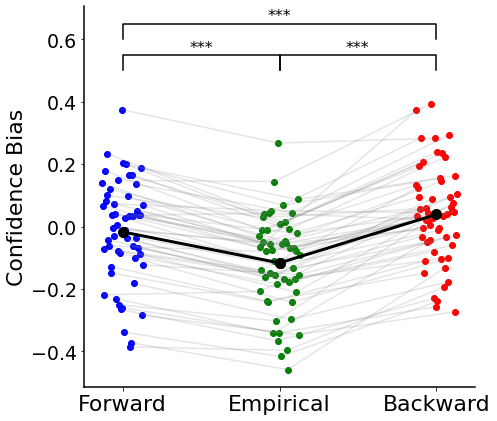

In [465]:
plt.figure(figsize=(7, 7))

groups = ["Forward", "Empirical", "Backward"]

comparison_plot(
    avg_df,
    "conf_bias",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [.5, .5, .6],
    [0.05, 0.05, 0.05],
    legend="lower right",
    y_label="Confidence Bias",
)

plt.savefig("../figs/confs_bias_compare.png", dpi=400, bbox_inches = "tight")

Statistics=0.0, p=1.626e-10


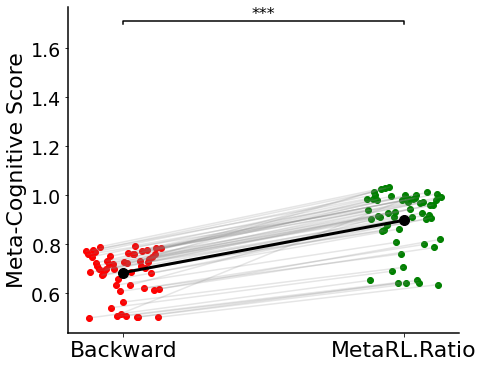

In [314]:
plt.figure(figsize=(7, 6))

mrl_df = forward_avg_df.copy()
mrl_df["cor"] = backward_avg_df["cor"] / forward_avg_df["cor"]

groups = ["Backward", "MetaRL.Ratio"]

measure_compare_df = merge_result_df([backward_avg_df, mrl_df], groups, 200, subjects)
comparison_plot(
    measure_compare_df,
    "cor",
    groups,
    "",
    [groups],
    [1.7],
    [0.01],
    y_label="Meta-Cognitive Score",
)
plt.savefig("../figs/Meta_Cognitive_Score.png", dpi=400)

In [22]:
emp_qsr_df = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
emp_ac_df = (
    lv_induction_data.groupby("sub")[["cor", "cj"]]
    .mean()
    .reset_index()
    .rename(columns={"cor": "emp_acc", "cj": "emp_cj", "sub": "subject"})
)

backward_emp_df = pd.merge(backward_avg_df, emp_qsr_df, on=["subject"])
backward_emp_df = pd.merge(backward_emp_df, emp_ac_df, on=["subject"])
backward_emp_df = pd.merge(
    backward_emp_df, scaled_brier_df[["subject", "scaled_QSR"]], on=["subject"]
)

backward_emp_df = backward_emp_df.rename(columns={"cor": "backward_cor"})
backward_emp_df["forward_cor"] = forward_avg_df["cor"]
backward_emp_df["MetaRL"] = (
    backward_emp_df["backward_cor"] / backward_emp_df["forward_cor"]
)

backward_emp_df["MetaRL_unscaled"] =  backward_unscaled_avg_df["cor"] / backward_emp_df["forward_cor"]
backward_emp_df["conf_bias"] = linear_transform_on_array(backward_emp_df["emp_cj"], [1,5], [0,1]) - backward_emp_df["emp_acc"]


## Backward Performance and QSR regression

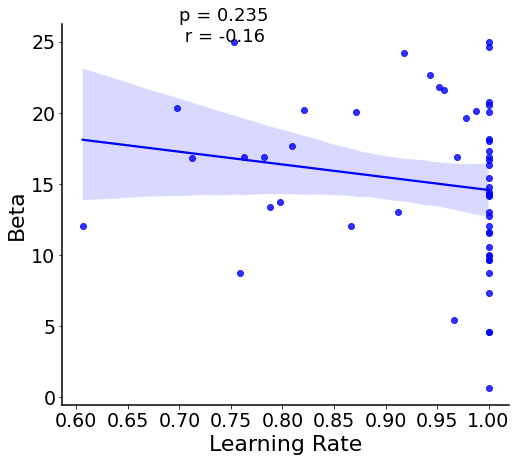

In [512]:
plt.figure(figsize=(8, 7))

stat, pval = scipy.stats.pearsonr(forward_df["alpha"], forward_df["beta"])


seaborn.regplot(data=forward_df, x="alpha", y="beta", color="blue", label= "Forwarad Model")

plt.ylabel("Beta", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.7, 25, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Forward_Params_Correlation.png", dpi=400, bbox_inches='tight')


plt.show()

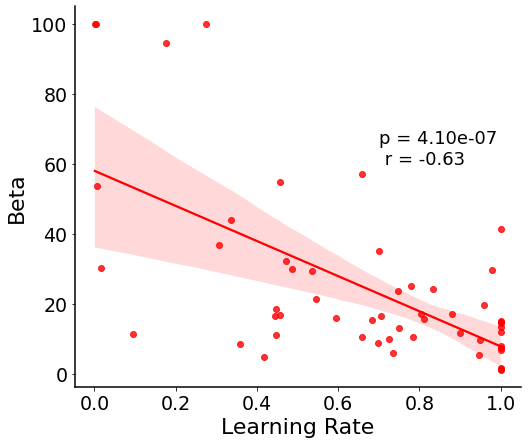

In [513]:
plt.figure(figsize=(8, 7))

stat, pval = scipy.stats.pearsonr(backward_df["alpha"], backward_df["beta"])


seaborn.regplot(data=backward_df, x="alpha", y="beta", color="red", label= "Backward Model")

plt.ylabel("Beta", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.7, 60, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Backward_Params_Correlation.png", dpi=400, bbox_inches='tight')


plt.show()

In [510]:
pval

4.10215553148509e-07

In [70]:
from matplotlib.legend_handler import HandlerTuple

def plot_regression_df(df,x, y, color, pos_x, pos_y, xlabel, ylabel):
    

    res = scipy.stats.pearsonr(df[x], df[y])

    stat_fwd_lr, pval= res 
    r_low, r_high = res.confidence_interval(.95)
    print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat_fwd_lr,r_low,r_high))

    seaborn.regplot(data=df, x=x, y=y, color= color, label= "Forwarad Model")

    plt.ylabel(ylabel, fontsize=22)
    plt.xlabel(xlabel, fontsize=22)

    ax = plt.gca()
    # hide x-axis
    for axis in ["top", "bottom", "left", "right"]:
        ax.spines[axis].set_linewidth(1.5)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.xticks(fontsize=19)
    plt.yticks(fontsize=19)
    plt.text(pos_x, pos_y, "p = {:.2e} \n r = {:.2f}".format(pval, stat_fwd_lr), fontsize=18)
    

(p = 1.36e-04, r = 0.50,ci = [0.26,0.67])
(p = 3.12e-03, r = 0.39,ci = [0.14,0.60])


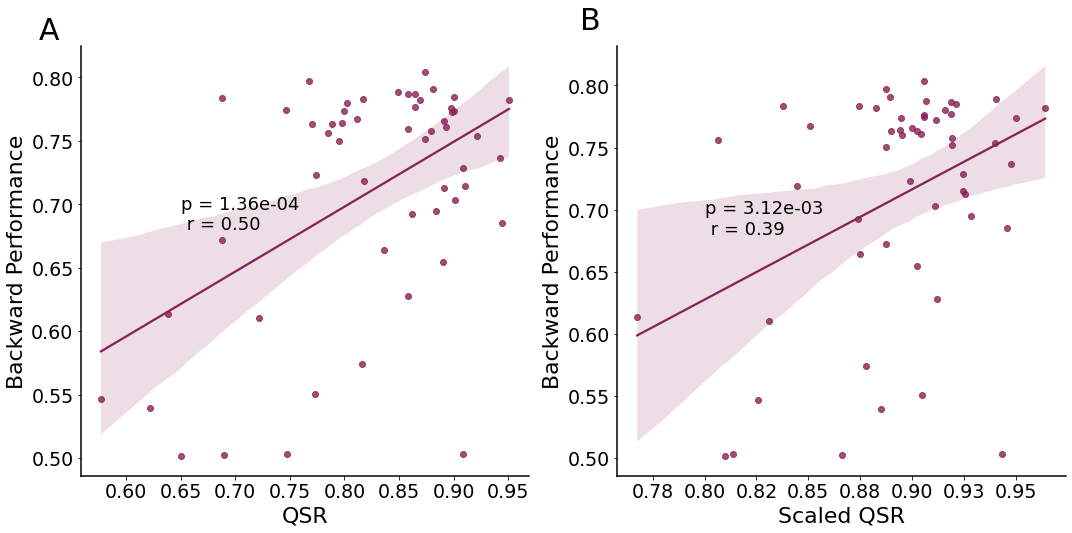

In [143]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(15, 7.5))

plt.subplot(1,2,1)

plot_regression_df(backward_emp_df, "QSR", "backward_cor", color_dict["Backward"] ,0.65, 0.68, "QSR", "Backward Performance")

plt.text(.52, .83, "A", fontsize=30)

plt.subplot(1,2,2)

plt.text(.74, .845, "B", fontsize=30)


plot_regression_df(backward_emp_df, "scaled_QSR", "backward_cor", color_dict["Backward"] ,0.8, 0.68, "Scaled QSR", "Backward Performance")

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/Backward_perf_Qsr.png", dpi=400, bbox_inches = "tight")



(p = 1.36e-04, r = 0.50,ci = [0.26,0.67])


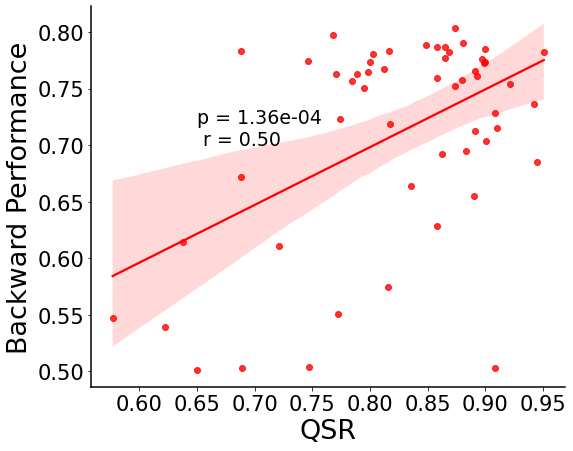

In [27]:
plt.figure(figsize=(8.5, 7))


seaborn.regplot(
    data=backward_emp_df,
    x="QSR",
    y="backward_cor",
    label="Backward Performance",
    color="red",
)

res = scipy.stats.pearsonr(
    backward_emp_df["QSR"], backward_emp_df["backward_cor"]
)

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.ylabel("Backward Performance", fontsize=27)
plt.xlabel("QSR", fontsize=27)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.text(0.65, 0.7, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=19)

plt.savefig("../figs/Perf_Qsr_reg.png", dpi=400, bbox_inches = "tight")


plt.show()

In [515]:
r1  = 0.4873208578981278
r2 = 0.39232720851626385


0.4873208578981278

In [517]:
stat


0.39232720851626385

(p = 3.34e-03, r = 0.39,ci = [0.14,0.60])


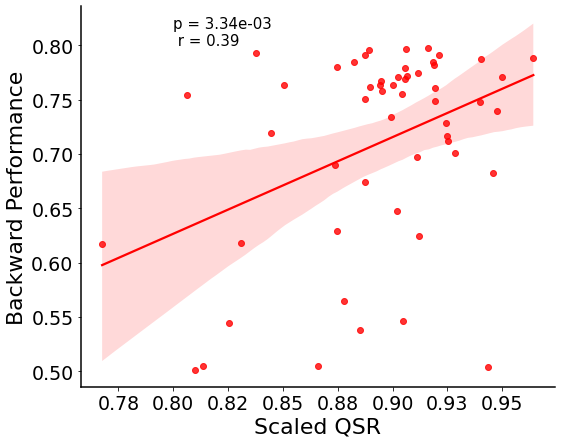

In [516]:
from matplotlib.ticker import StrMethodFormatter

plt.figure(figsize=(8.5, 7))


seaborn.regplot(
    data=backward_emp_df,
    x="scaled_QSR",
    y="backward_cor",
    label="Backward Performance",
    color="red",
)

res = scipy.stats.pearsonr(
    backward_emp_df["scaled_QSR"], backward_emp_df["backward_cor"]
)

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f},ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.ylabel("Backward Performance", fontsize=22)
plt.xlabel("Scaled QSR", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(0.8, 0.8, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=15)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.savefig("../figs/Perf_scaledQsr_reg.png", dpi=400, bbox_inches = "tight")

plt.show()

## MetaRL and QSR regression

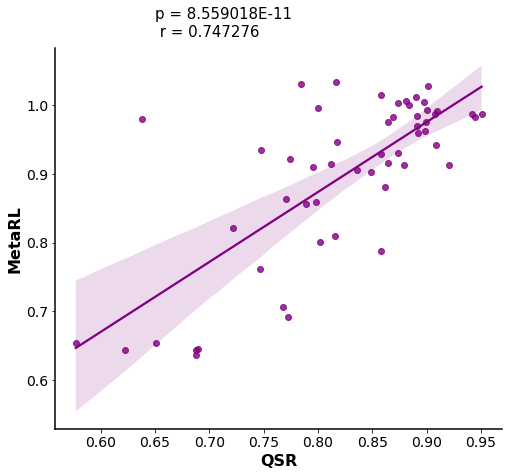

In [320]:
plt.figure(figsize=(8, 7))


stat, pval = scipy.stats.pearsonr(backward_emp_df["QSR"], backward_emp_df["MetaRL"])


seaborn.regplot(data=backward_emp_df, x="QSR", y="MetaRL", color="purple")

plt.ylabel("MetaRL", fontsize=16, fontweight="bold")
plt.xlabel("QSR", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 1.1, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.savefig("../figs/Meta_RL_QSR_reg.png", dpi=400)

plt.show()

## QSR regressions 

(p = 1.13e-11, r = 0.77, ci = [0.63,0.86])


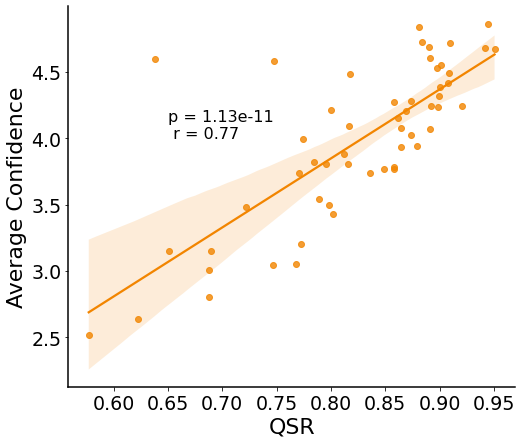

In [495]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="QSR",
    y="emp_cj",
    label="Backward Performance",
    color="#f28500",
)

res = scipy.stats.pearsonr(backward_emp_df["QSR"], backward_emp_df["emp_cj"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.xlabel("QSR", fontsize=22)
plt.ylabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.65, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=16)

plt.savefig("../figs/QSR_avg_conf.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 1.24e-04, r = 0.50, ci = [0.27,0.68])


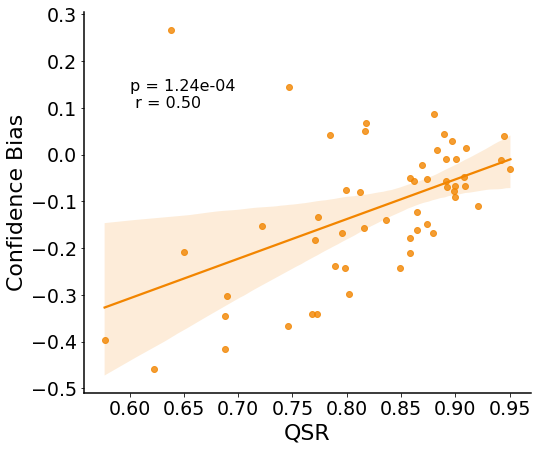

In [492]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="QSR",
    y="conf_bias",
    label="Backward Performance",
    color="#f28500",
)

res = scipy.stats.pearsonr(backward_emp_df["QSR"], backward_emp_df["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.xlabel("QSR", fontsize=22)
plt.ylabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.6, .1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=16)

# plt.savefig("../figs/QSR_avg_conf.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 4.13e-01, r = -0.11, ci = [-0.37,0.16])


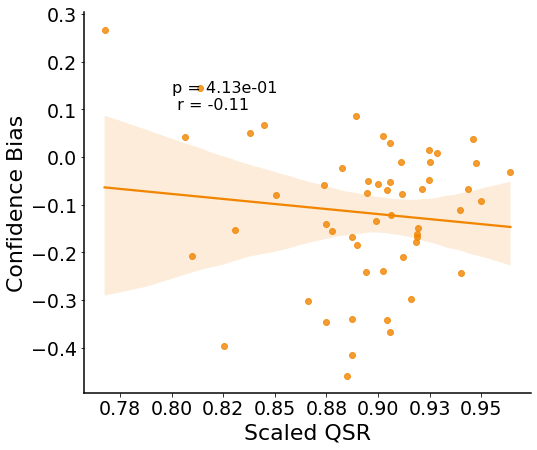

In [490]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="scaled_QSR",
    y="conf_bias",
    label="Backward Performance",
    color="#f28500",
)

res = scipy.stats.pearsonr(backward_emp_df["scaled_QSR"], backward_emp_df["conf_bias"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.xlabel("Scaled QSR", fontsize=22)
plt.ylabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.8, .1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=16)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# plt.savefig("../figs/QSR_avg_conf.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 1.13e-11, r = 0.77,ci = [0.63,0.86])
(p = 2.26e-02, r = 0.31,ci = [0.05,0.53])


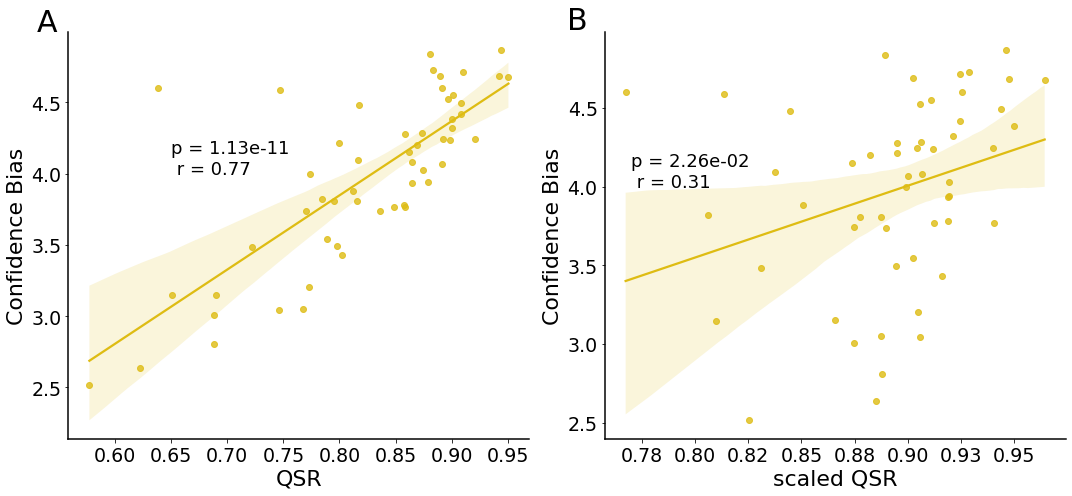

In [174]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(15, 7))

plt.subplot(1,2,1)

plt.text(.53, 5, "A", fontsize=30)

plot_regression_df(backward_emp_df, "QSR", "emp_cj", "#DEBC13",0.65, 4, "QSR", "Confidence Bias")


plt.subplot(1,2,2)
plt.text(.74, 5, "B", fontsize=30)

plot_regression_df(backward_emp_df, "scaled_QSR", "emp_cj", "#DEBC13",0.77, 4, "scaled QSR", "Confidence Bias")

ax = plt.gca()

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/scaledQSR-confbias.png", dpi=400, bbox_inches='tight')


In [519]:
r1  = 0.4873208578981278
r2 = 0.39232720851626385
compare_correlations(r1, r2, n1, n2)

(0.5958359262039669, 0.5512848407992752)

In [ ]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="QSR",
    y="emp_cj",
    label="Backward Performance",
    color="#f28500",
)

res = scipy.stats.pearsonr(backward_emp_df["QSR"], backward_emp_df["emp_cj"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.xlabel("QSR", fontsize=22)
plt.ylabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.65, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=16)

plt.savefig("../figs/QSR_avg_conf.png", dpi=400, bbox_inches = "tight")

plt.show()

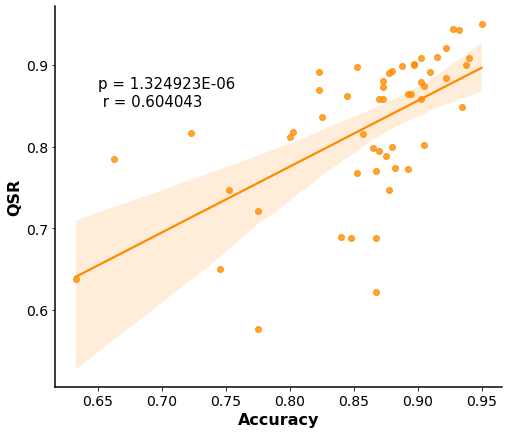

In [322]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="emp_acc",
    y="QSR",
    label="Backward Performance",
    color="darkorange",
)

stat, pval = scipy.stats.pearsonr(backward_emp_df["emp_acc"], backward_emp_df["QSR"])

plt.ylabel("QSR", fontsize=16, fontweight="bold")
plt.xlabel("Accuracy", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 0.85, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.show()

## Scaled QSR regressions

(p = 2.26e-02, r = 0.31, ci = [0.05,0.53])


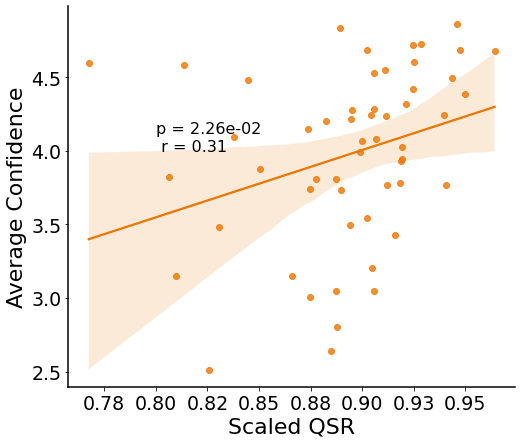

In [498]:
from matplotlib.ticker import FormatStrFormatter

plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="scaled_QSR",
    y="emp_cj",
    label="Backward Performance",
    color="#ee7600",
)

res = scipy.stats.pearsonr(
    backward_emp_df["scaled_QSR"], backward_emp_df["emp_cj"]
)

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


plt.xlabel("Scaled QSR", fontsize=22)
plt.ylabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.80, 4, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=16)

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))


plt.savefig("../figs/scaled_QSR_avg_conf.png", dpi=400, bbox_inches = "tight")

plt.show()

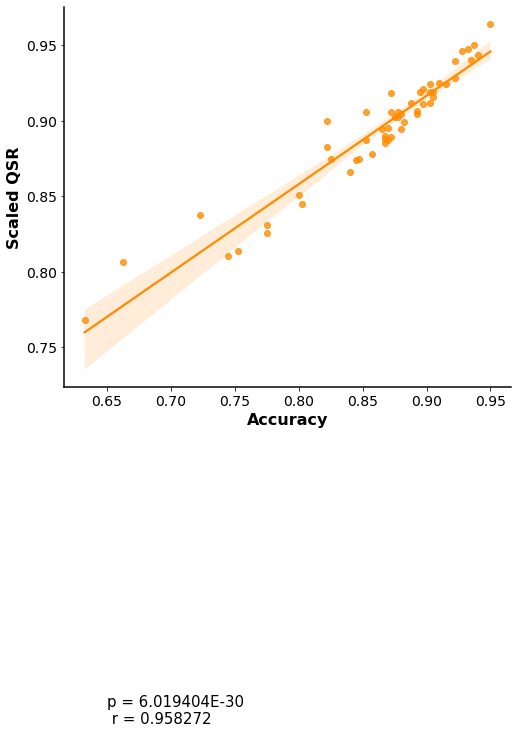

In [324]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="emp_acc",
    y="scaled_QSR",
    label="Backward Performance",
    color="darkorange",
)

stat, pval = scipy.stats.pearsonr(
    backward_emp_df["emp_acc"], backward_emp_df["scaled_QSR"]
)

plt.ylabel("Scaled QSR", fontsize=16, fontweight="bold")
plt.xlabel("Accuracy", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 0.5, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.show()

## Backward Performance regressions

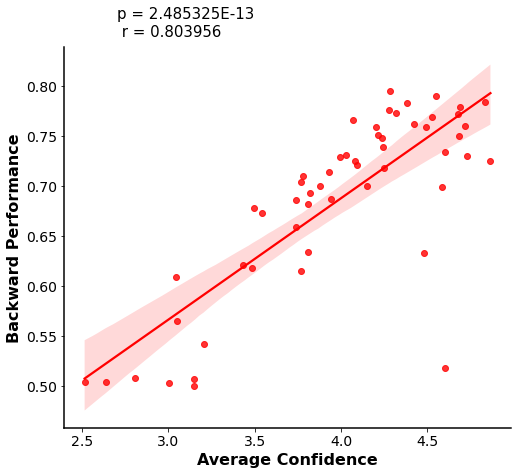

In [325]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="emp_cj",
    y="backward_cor",
    label="Backward Performance",
    color="red",
)

stat, pval = scipy.stats.pearsonr(
    backward_emp_df["emp_cj"], backward_emp_df["backward_cor"]
)

plt.ylabel("Backward Performance", fontsize=16, fontweight="bold")
plt.xlabel("Average Confidence", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(2.7, 0.85, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.show()

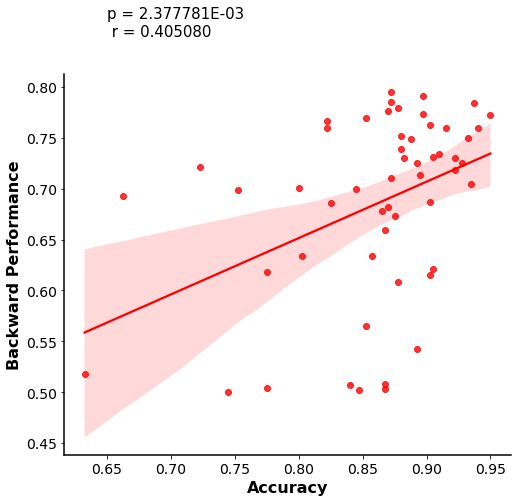

In [326]:
plt.figure(figsize=(8, 7))

seaborn.regplot(
    data=backward_emp_df,
    x="emp_acc",
    y="backward_cor",
    label="Backward Performance",
    color="red",
)

stat, pval = scipy.stats.pearsonr(
    backward_emp_df["emp_acc"], backward_emp_df["backward_cor"]
)

plt.ylabel("Backward Performance", fontsize=16, fontweight="bold")
plt.xlabel("Accuracy", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 0.85, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.show()

## Meta.RL ratio regressions

(p = 5.99e-01, r = -0.07, ci = [-0.33,0.20])


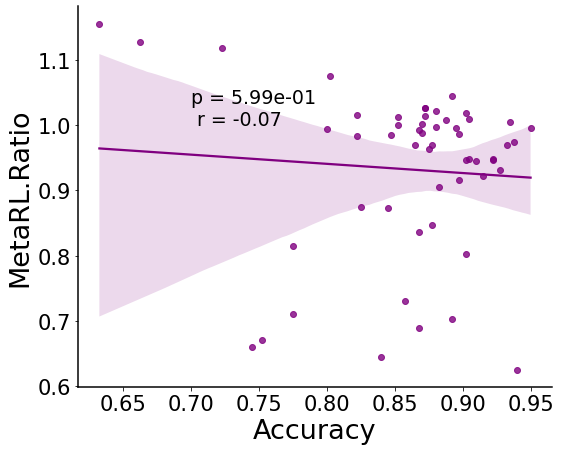

In [30]:
plt.figure(figsize=(8.5, 7))


res = scipy.stats.pearsonr(backward_emp_df["emp_acc"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=backward_emp_df, x="emp_acc", y="MetaRL", color="purple")


plt.ylabel("MetaRL.Ratio", fontsize=27)
plt.xlabel("Accuracy", fontsize=27)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)
plt.text(0.7, 1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=19)

plt.savefig("../figs/MetaRl_acc.png", dpi=400, bbox_inches = "tight")


plt.show()

(p = 4.89e-01, r = 0.10, ci = [-0.18,0.35])


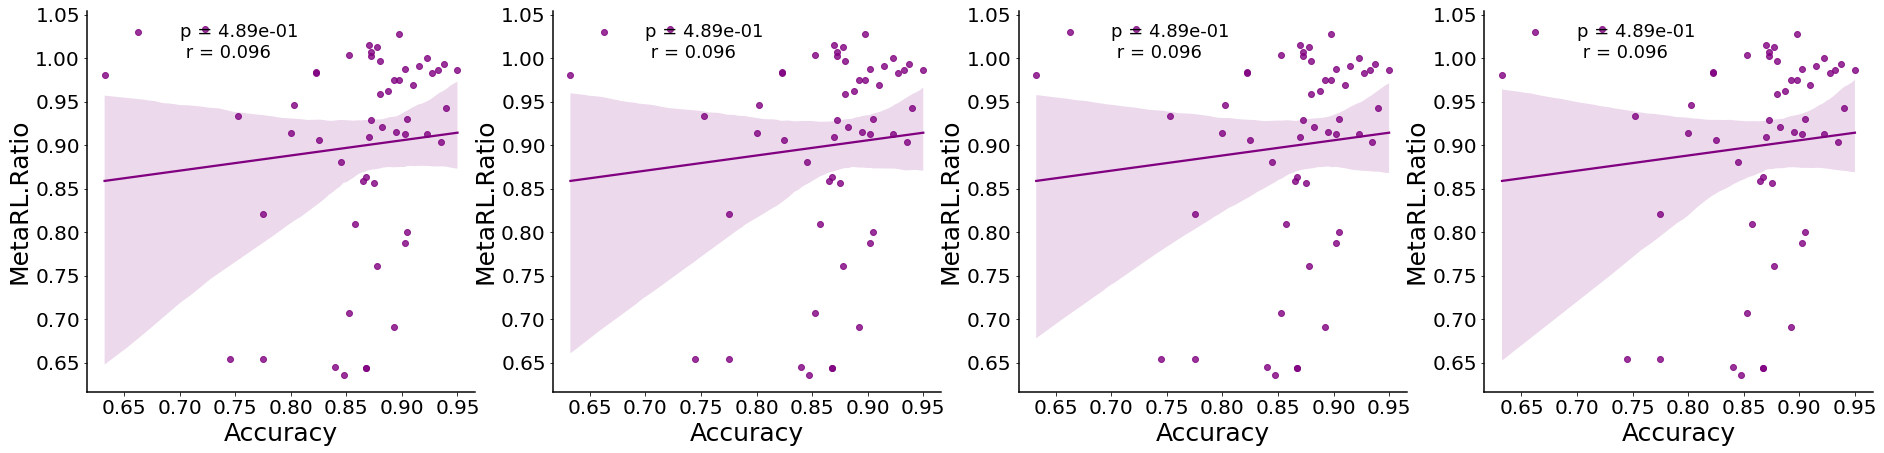

In [349]:
plt.figure(figsize=(32, 7))

plt.subplot(1,4,1)

res = scipy.stats.pearsonr(backward_emp_df["emp_acc"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=backward_emp_df, x="emp_acc", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=25)
plt.xlabel("Accuracy", fontsize=25)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.7, 1, "p = {:.2e} \n r = {:.3f}".format(pval, stat), fontsize=18)

plt.subplot(1,4,2)

seaborn.regplot(data=backward_emp_df, x="emp_acc", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=25)
plt.xlabel("Accuracy", fontsize=25)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.7, 1, "p = {:.2e} \n r = {:.3f}".format(pval, stat), fontsize=18)

plt.subplot(1,4,3)

seaborn.regplot(data=backward_emp_df, x="emp_acc", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=25)
plt.xlabel("Accuracy", fontsize=25)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.7, 1, "p = {:.2e} \n r = {:.3f}".format(pval, stat), fontsize=18)


plt.subplot(1,4,4)

seaborn.regplot(data=backward_emp_df, x="emp_acc", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=25)
plt.xlabel("Accuracy", fontsize=25)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.text(0.7, 1, "p = {:.2e} \n r = {:.3f}".format(pval, stat), fontsize=18)


plt.savefig("../figs/Cosyne_test.png", dpi=400, bbox_inches = "tight")


plt.show()

(p = 5.99e-01, r = -0.07,ci = [-0.33,0.20])
(p = 8.60e-03, r = 0.35, ci = [0.10,0.57])
(p = 1.93e-01, r = 0.18,ci = [-0.09,0.43])
(p = 5.51e-01, r = -0.08,ci = [-0.34,0.19])


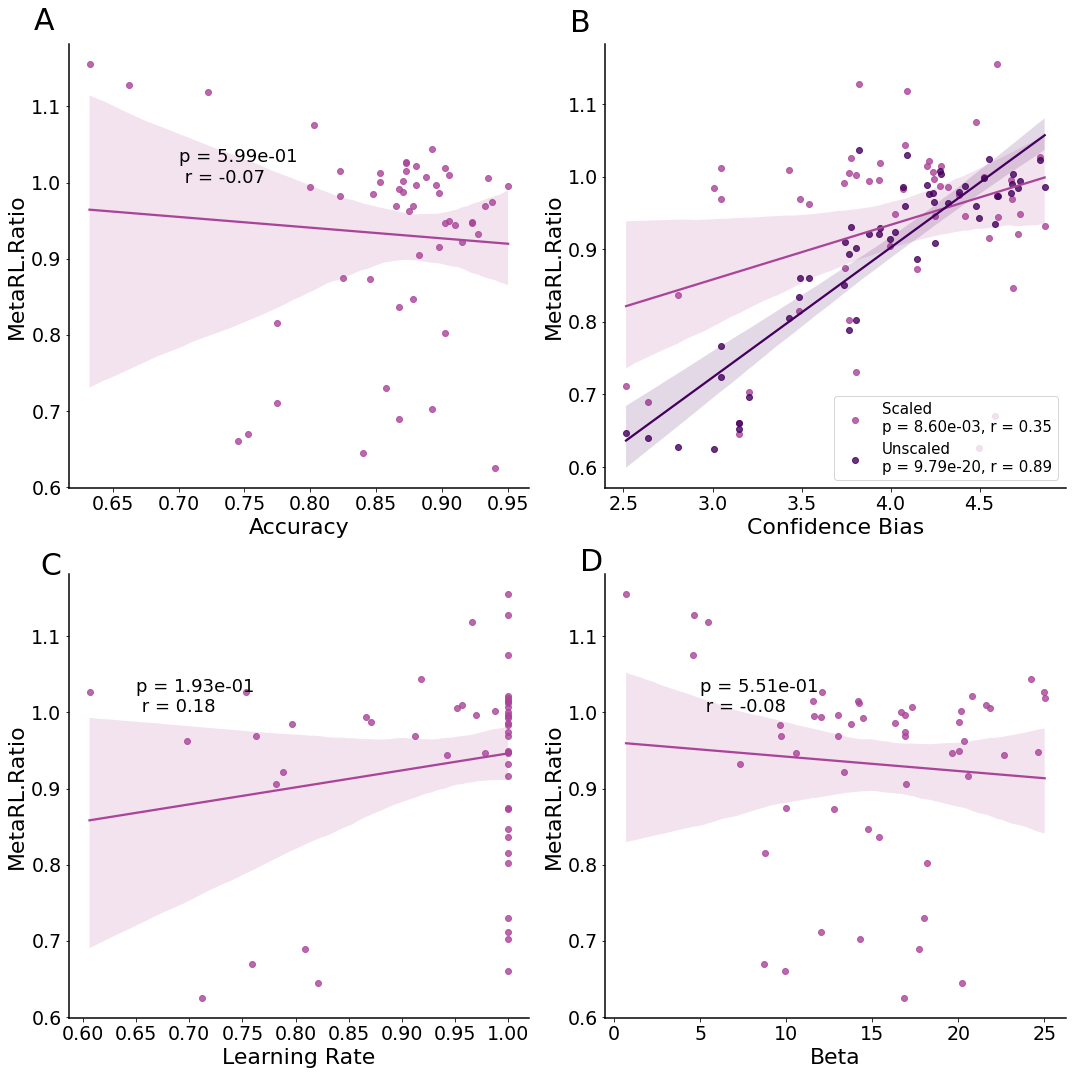

In [150]:
plt.figure(figsize=(15, 15))

plt.subplot(2,2,1)

plt.text(.59, 1.2, "A", fontsize=30)

plot_regression_df(backward_emp_df, "emp_acc", "MetaRL", "#AA4499",0.7, 1, "Accuracy", "MetaRL.Ratio")


plt.subplot(2,2,2)

plt.text(2.2, 1.2, "B", fontsize=30)

res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

res2 = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

stat2, pval2= res2 
r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL", color="#AA4499", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="#44005D", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.legend(fontsize=15, loc = "lower right")


plt.subplot(2,2,3)

plt.text(.56, 1.18, "C", fontsize=30)

plot_regression_df(backward_with_params, "alpha", "MetaRL", "#AA4499",0.65, 1, "Learning Rate", "MetaRL.Ratio")

plt.subplot(2,2,4)

plt.text(-2, 1.185, "D", fontsize=30)

plot_regression_df(backward_with_params, "beta", "MetaRL", "#AA4499", 5, 1, "Beta", "MetaRL.Ratio")


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.savefig("../figs/MetaRl_Regs.png", dpi=400, bbox_inches = "tight")



(p = 8.60e-03, r = 0.35, ci = [0.10,0.57])


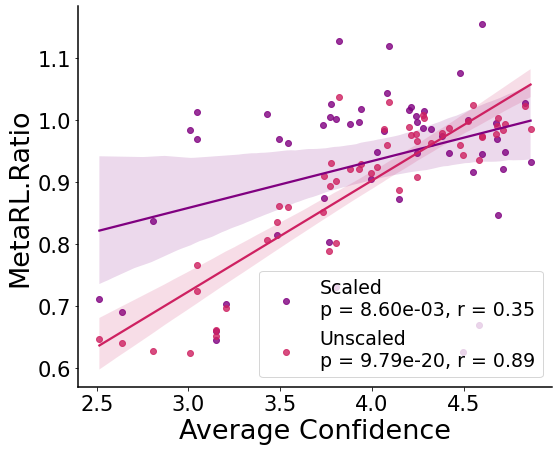

In [132]:
plt.figure(figsize=(8.5, 7))


res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

res2 = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

stat2, pval2= res2 
r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL", color="purple", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="#CE2161", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio", fontsize=27)
plt.xlabel("Average Confidence", fontsize=27)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.legend(fontsize=19, loc = "lower right")


plt.savefig("../figs/MetaRl_avgconf_unscaled.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 1.20e-19, r = 0.89, ci = [0.82,0.94])


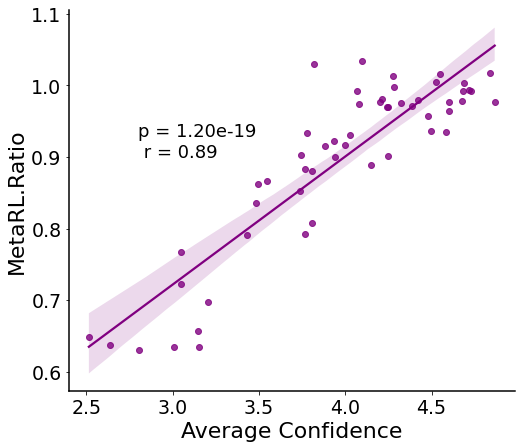

In [405]:
plt.figure(figsize=(8, 7))


res = scipy.stats.pearsonr(backward_emp_df["emp_cj"], backward_emp_df["MetaRL_unscaled"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=backward_emp_df, x="emp_cj", y="MetaRL_unscaled", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(2.8, .9, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)


plt.savefig("../figs/MetaRl_avgconf.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 2.01e-16, r = 0.85, ci = [0.76,0.91])


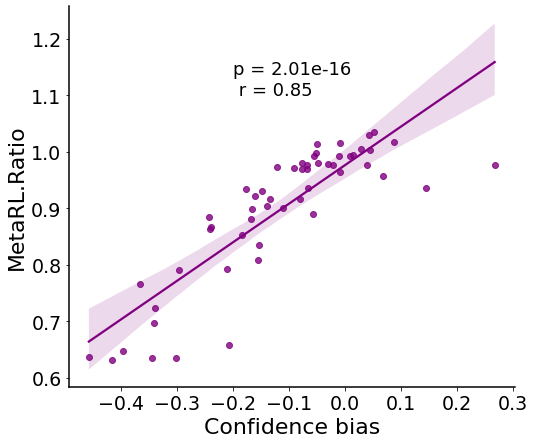

In [406]:
plt.figure(figsize=(8, 7))


res = scipy.stats.pearsonr(backward_emp_df["conf_bias"], backward_emp_df["MetaRL_unscaled"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))



seaborn.regplot(data=backward_emp_df, x="conf_bias", y="MetaRL_unscaled", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Confidence Bias", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(-.2, 1.1, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)


plt.savefig("../figs/MetaRl_conf_bias.png", dpi=400, bbox_inches = "tight")

plt.show()

(p = 4.09e-03, r = 0.38, ci = [0.13,0.59])


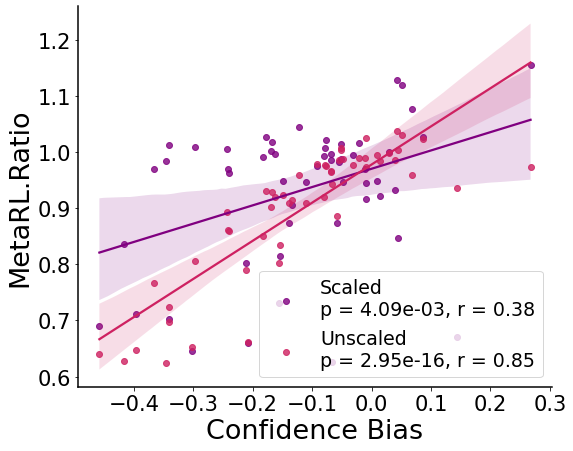

In [29]:
plt.figure(figsize=(8.5, 7))


res = scipy.stats.pearsonr(backward_emp_df["conf_bias"], backward_emp_df["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))

res2 = scipy.stats.pearsonr(backward_emp_df["conf_bias"], backward_emp_df["MetaRL_unscaled"])

stat2, pval2= res2 
r_low, r_high = res.confidence_interval(.95)



seaborn.regplot(data=backward_emp_df, x="conf_bias", y="MetaRL", color="purple", label = "Scaled\np = {:.2e}, r = {:.2f}".format(pval, stat))

seaborn.regplot(data=backward_emp_df, x="conf_bias", y="MetaRL_unscaled", color="#CE2161", label = "Unscaled\np = {:.2e}, r = {:.2f}".format(pval2, stat2))


plt.ylabel("MetaRL.Ratio", fontsize=27)
plt.xlabel("Confidence Bias", fontsize=27)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=21)
plt.yticks(fontsize=21)

plt.legend(fontsize=19, loc = "lower right")


plt.savefig("../figs/MetaRl_conf_bias.png", dpi=400, bbox_inches = "tight")

plt.show()

In [426]:
import numpy as np
from scipy import stats

def fisher_z_transform(r):
    """Compute Fisher Z transformation of a correlation coefficient."""
    return 0.5 * np.log((1 + r) / (1 - r))

def compare_correlations(r1, r2, n1, n2):
    """Compare two correlation coefficients using Fisher Z transformation."""
    # Calculate Fisher Z transformations
    Z1 = fisher_z_transform(r1)
    Z2 = fisher_z_transform(r2)

    # Calculate standard errors
    SE1 = 1 / np.sqrt(n1 - 3)
    SE2 = 1 / np.sqrt(n2 - 3)

    # Calculate Z-score for the difference
    Z_diff = (Z1 - Z2) / np.sqrt(SE1**2 + SE2**2)

    # Calculate p-value
    p_value = 2 * (1 - stats.norm.cdf(np.abs(Z_diff)))

    return Z_diff, p_value

# Example usage with hypothetical correlation coefficients and sample sizes
r1 = stat  # Correlation coefficient from dataset 1
r2 = stat2 # Correlation coefficient from dataset 2
n1 = len(backward_emp_df)  # Sample size of dataset 1
n2 = len(backward_emp_df)  # Sample size of dataset 2

Z_diff, p_value = compare_correlations(r1, r2, n1, n2)
Z_diff, p_value



(-4.304424605900996, 1.6742029403493675e-05)

In [475]:
r2 = 0.5694196695302497

r1 = 0.34509707495693626

Z_diff, p_value = compare_correlations(r1, r2, n1, n2)
Z_diff, p_value


(-1.448250936929372, 0.147546883698761)

In [105]:
backward_with_params = pd.merge(backward_emp_df, forward_df, on =["subject"])
backward_with_params

,subject,reward,backward_cor,cj,model_x,x_idx_x,QSR,emp_acc,emp_cj,scaled_QSR,...,Unnamed: 0,alpha,beta,lbound,bound_range,LL,Confidence Distance,hbound,model_y,x_idx_y
0,45628,0.556123,0.781950,4.681837,Backward,401,0.950689,0.9500,4.676476,0.964184,...,0,1.000000,11.609160,4.605658,0.227874,137.997922,0.774465,4.695518,Forward,1
1,45640,0.500986,0.503100,4.503303,Backward,402,0.908498,0.9400,4.494590,0.943576,...,1,0.712177,16.827742,4.462571,0.071960,114.860509,0.418840,4.501244,Forward,2
2,45664,0.501033,0.501500,3.141730,Backward,403,0.650582,0.7450,3.148277,0.809975,...,2,1.000000,9.946770,3.148277,0.000000,164.286110,1.549730,3.148277,Forward,3
3,45682,0.536076,0.664100,4.015696,Backward,404,0.835839,0.8250,3.741547,0.874732,...,3,1.000000,10.014854,1.488940,0.821553,144.475233,0.728441,4.373464,Forward,4
4,45745,0.547352,0.736525,4.728367,Backward,405,0.942243,0.9325,4.684585,0.947470,...,4,1.000000,9.672207,4.092176,0.945758,188.692218,0.437737,4.950758,Forward,5
5,45760,0.552887,0.759750,4.413852,Backward,406,0.858255,0.8700,4.276919,0.894994,...,5,0.871313,20.041560,1.000000,0.929745,80.950285,0.551919,4.718982,Forward,6
6,45763,0.555206,0.776075,4.343007,Backward,407,0.897237,0.8525,4.526510,0.905752,...,6,1.000000,16.674608,2.498130,0.881425,59.649345,0.963744,4.703341,Forward,7
7,45805,0.537048,0.685175,4.866136,Backward,408,0.944388,0.9275,4.865320,0.945996,...,7,1.000000,7.342098,4.681814,0.879262,206.220459,0.245971,4.961583,Forward,8
8,45829,0.558429,0.777050,3.990812,Backward,409,0.864965,0.8950,3.932559,0.918932,...,8,1.000000,13.006700,1.294533,0.847562,111.491052,0.743770,4.435145,Forward,9
9,45964,0.554388,0.767250,4.025866,Backward,410,0.811892,0.8000,3.879826,0.850612,...,9,0.866118,12.043129,1.579689,0.823172,123.916290,0.823909,4.395193,Forward,10


(p = 3.59e-01, r = 0.13, ci = [-0.15,0.38])


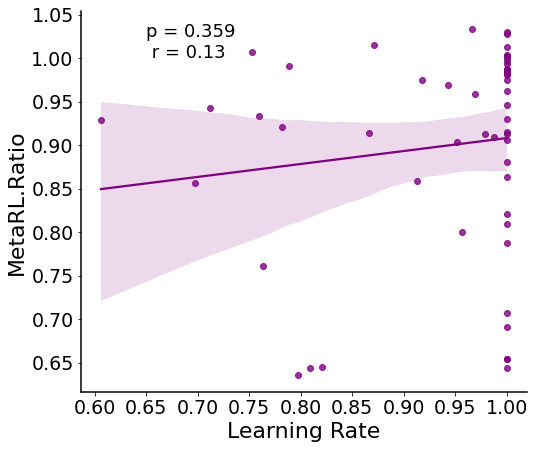

In [472]:
plt.figure(figsize=(8, 7))


res = scipy.stats.pearsonr(backward_with_params["alpha"], backward_with_params["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=backward_with_params, x="alpha", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Learning Rate", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.65, 1.0, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/MetaRl_learningrate.png", dpi=400, bbox_inches = "tight")


plt.show()

(p = 7.22e-01, r = -0.05, ci = [-0.31,0.22])


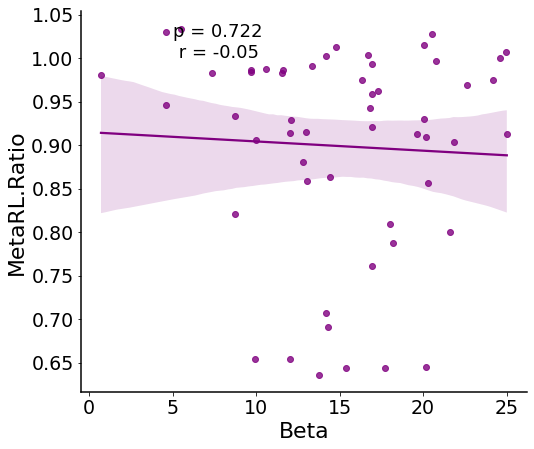

In [471]:
plt.figure(figsize=(8, 7))


res = scipy.stats.pearsonr(backward_with_params["beta"], backward_with_params["MetaRL"])

stat, pval= res 
r_low, r_high = res.confidence_interval(.95)
print("(p = {:.2e}, r = {:.2f}, ci = [{:.2f},{:.2f}])".format(pval, stat,r_low,r_high))


seaborn.regplot(data=backward_with_params, x="beta", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(5, 1, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/MetaRl_beta.png", dpi=400, bbox_inches = "tight")


plt.show()

In [333]:
df_back_params = pd.merge(backward_emp_df, backward_df, on =["subject"])

In [334]:
plt.figure(figsize=(8, 7))


stat, pval = scipy.stats.pearsonr(df_back_params["emp_cj"], df_back_params["lbound"])


seaborn.regplot(data=df_back_params, x="emp_cj", y="lbound", color="red")

plt.ylabel("Lower Bound " + r"$(L_c)$", fontsize=22)
plt.xlabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(3, 3.5, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/Lbound_avg_conf.png", dpi=400, bbox_inches = "tight")


plt.show()

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: Image size of 3061x-1755622853 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 553x285283308 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x504 with 1 Axes>

In [ ]:
plt.figure(figsize=(8, 7))


stat, pval = scipy.stats.pearsonr(df_back_params["emp_cj"], df_back_params["hbound"])


seaborn.regplot(data=df_back_params, x="emp_cj", y="hbound", color="red")

plt.ylabel("Upper Bound " + r"$(H_c)$", fontsize=22)
plt.xlabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(3, 4.5, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/hbound_avg_conf.png", dpi=400, bbox_inches = "tight")


plt.show()

In [335]:
plt.figure(figsize=(8, 7))

df_back_params["midbound"] = (df_back_params["hbound"] + df_back_params["lbound"])/2

stat, pval = scipy.stats.pearsonr(df_back_params["emp_cj"], df_back_params["midbound"])


seaborn.regplot(data=df_back_params, x="emp_cj", y="midbound", color="red")

plt.ylabel("Mid of Bounds " + r"$(H_c + L_c)/2$", fontsize=22)
plt.xlabel("Average Confidence", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(3, 4.5, "p = {:.2e} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/midbound_avg_conf.png", dpi=400, bbox_inches = "tight")


plt.show()

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


ValueError: Image size of 2893x-118147314 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 523x837726943 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x504 with 1 Axes>

## Scale parameters and confidence bias

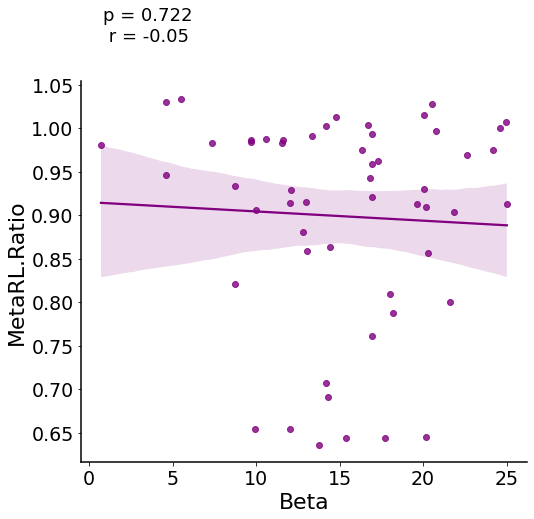

In [336]:
plt.figure(figsize=(8, 7))


stat, pval = scipy.stats.pearsonr(backward_with_params["beta"], backward_with_params["MetaRL"])


seaborn.regplot(data=backward_with_params, x="beta", y="MetaRL", color="purple")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.85, 1.1, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/MetaRl_beta.png", dpi=400, bbox_inches = "tight")


plt.show()

## Subjects MetaRL.Ratio Distribution 

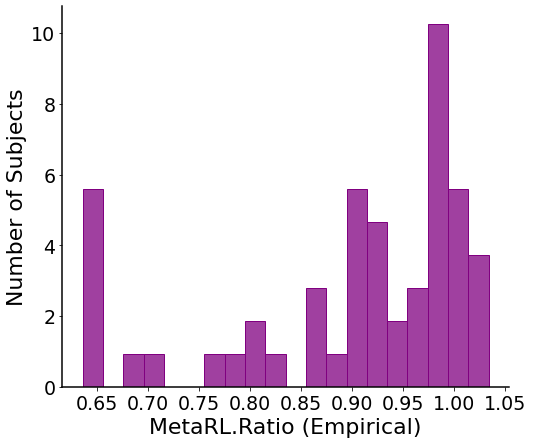

In [337]:
plt.figure(figsize=(8, 7))

seaborn.histplot(
    data=backward_emp_df,
    x="MetaRL",
    color="purple",
    stat="density",
    bins=20,
    edgecolor="purple",
)

plt.ylabel("Number of Subjects", fontsize=22)
plt.xlabel("MetaRL.Ratio (Empirical)", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)

plt.savefig("../figs/Meta_RL_hist.png", dpi=400)

plt.show()

In [72]:
lv_induction_data

,sub,condition,cresp,resp,cor,cj,phase,trial,trial_rev,reward,Lreward,Hreward
0,45628,hc,0,1,0,1.000000,induction,0,19,0.595649,59.564905,62.587240
1,45628,hc,0,0,1,1.000000,induction,1,18,0.531705,51.884986,53.170477
2,45628,hc,0,1,0,1.000000,induction,2,17,0.395744,39.574438,46.393013
3,45628,hc,0,0,1,1.000000,induction,3,16,0.657494,33.232232,65.749407
4,45628,hc,0,0,1,3.555556,induction,4,15,0.750121,44.238900,75.012120
...,...,...,...,...,...,...,...,...,...,...,...,...
94736,47743,hc,1,1,1,5.000000,induction,17,4,0.727834,31.483819,72.783385
94737,47743,hc,1,1,1,4.037037,induction,18,3,0.584612,36.177430,58.461153
94738,47743,hc,1,1,1,1.913580,induction,19,2,0.590103,36.688748,59.010261
94739,47743,hc,1,1,1,1.195286,induction,20,1,0.569270,42.462693,56.926954


## Confidences Auto Correlation

In [340]:
import statsmodels.api as sm
autocorrelations = []
lags = []
subject_cl = []
for sub in subjects:
    subject_data = lv_induction_data[lv_induction_data["sub"] == sub]
    acf = sm.tsa.acf(subject_data["cj"])
    autocorrelations.extend(acf)
    lags.extend(np.arange(len(acf)))
    subject_cl.extend([sub]*len(acf))
auto_corrleation_df = pd.DataFrame(zip(subject_cl,lags, autocorrelations), columns=["subjects","lags", "acf"])

In [413]:
round(auto_corrleation_df[auto_corrleation_df["lags"] == 1]["acf"].mean(),4)

0.5056

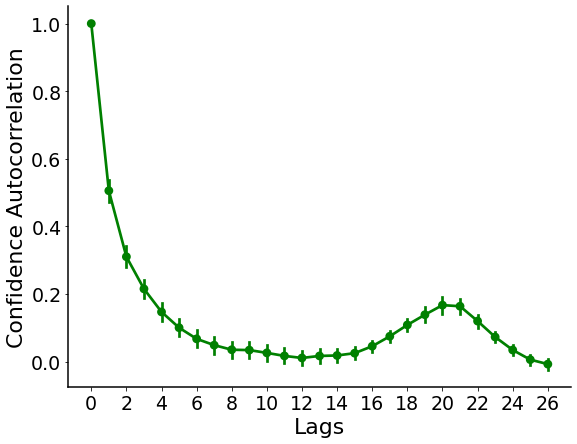

In [96]:
plt.figure(figsize=(9, 7))

seaborn.pointplot(data = auto_corrleation_df, x = "lags", y= "acf", color="green", errorbar="se")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


plt.xticks(fontsize=19)
plt.yticks(fontsize=19)


plt.xlabel("Lags", fontsize=22)
plt.ylabel("Confidence Autocorrelation", fontsize=22)

plt.locator_params(axis='x', nbins=15)


plt.show()

In [449]:
def mutual_information(state, action):
    from scipy.special import psi
    # Hutter estimator of mutual information.
    #
    # USAGE: I = mutual_information(state, action, [alpha])

    uS = np.unique(state)
    uA = np.unique(action)
    

    N = np.zeros((len(uS), len(uA)))
            
                 
    alpha = 1

    for x in range(len(uS)):
        for y in range(len(uA)):
            N[x, y] = alpha + np.sum((state == uS[x]) & (action == uA[y]))

    n = np.sum(N)
    nA = np.sum(N, axis=0, keepdims=True)
    nS = np.sum(N, axis=1, keepdims = True)
    
    P = psi(N + 1) - psi(nA + 1) - psi(nS + 1) + psi(n + 1)
    I = np.sum(N * P) / n

    return I

In [450]:
policy_complexity = []
for i in range(len(subjects)):
    states= lv_induction_data[lv_induction_data["sub"] == subjects[i]]["cresp"].to_numpy()
    actions = lv_induction_data[lv_induction_data["sub"] == subjects[i]]["resp"].to_numpy()
    policy_complexity.append(mutual_information(states, actions))

In [451]:
policy_complexity

[0.48361989507870773,
 0.45527934707629325,
 0.12460967282355828,
 0.2254784647354843,
 0.44067946010989745,
 0.30173283420633545,
 0.2701921042714041,
 0.4238104057185852,
 0.3499603697327259,
 0.19161780800159714,
 0.35695565776356797,
 0.311746010961697,
 0.2918499629429782,
 0.05364799964533444,
 0.25717891005719695,
 0.3713881718450291,
 0.10140053111379513,
 0.31971033616685524,
 0.3457412650869173,
 0.4113053094211512,
 0.1321445350566731,
 0.2786038208990457,
 0.2502405393360245,
 0.2972613562003075,
 0.316257580218748,
 0.03575388497061616,
 0.2697373401151615,
 0.4130694293232642,
 0.2968249622568388,
 0.3447036853847152,
 0.22162564234891935,
 0.2064383655310437,
 0.36578931940735904,
 0.3671930842549318,
 0.3938029028652927,
 0.30575903678832395,
 0.15787883955093862,
 0.2965004310822614,
 0.382244254476526,
 0.30609770958997917,
 0.35517328056569664,
 0.3723168263007821,
 0.4424850585823252,
 0.31573009408440816,
 0.3246927580657532,
 0.3208392451709786,
 0.302266949020609

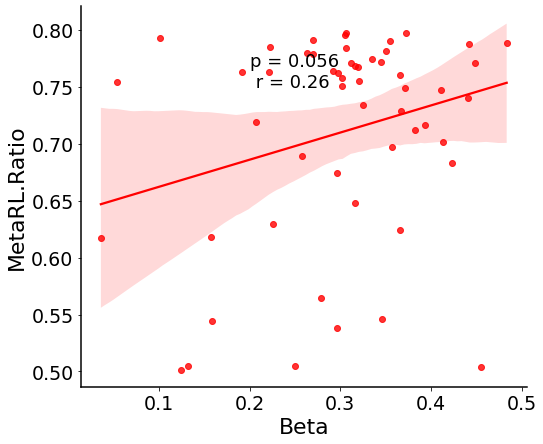

In [453]:
plt.figure(figsize=(8, 7))


stat, pval = scipy.stats.pearsonr(policy_complexity, backward_emp_df["backward_cor"])


seaborn.regplot(x=policy_complexity, y=backward_emp_df["backward_cor"], color="red")

plt.ylabel("MetaRL.Ratio", fontsize=22)
plt.xlabel("Beta", fontsize=22)

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.text(.2, .75, "p = {:.3f} \n r = {:.2f}".format(pval, stat), fontsize=18)

plt.savefig("../figs/MetaRl_beta.png", dpi=400, bbox_inches = "tight")


plt.show()